#  🏠 Data Mining Questions  <a id='home'></a>

Process of knowledge discovery from our dataset.

### 🛠️ [Initial Data Pull and Setup](#data_pull)

### ❓ [Data Mining Questions](#questions)
1. [Crime has steadily decreased since 2002, but plateaued in 2016.  Why might crime have plateaued?](#q1)
2. [Crime seems to be disappearing in some areas.  Which neighborhoods have gotten safer, and what might be some of the contributing factors?](#q2)
3. [Crime dropped off significantly in April of 2020.  What were the factors involved?](#q3)


# Part 1: Initial Data Pull and Setup <a id='data_pull'></a>
Links: [🏠](#home) [❓](#questions)

## Part 1a: Imports

In [1]:
# Std lib:
import warnings
import os

# To hide environment variables
from dotenv import load_dotenv

# Data manipulation:
import numpy as np
import pandas as pd
import geopandas
from shapely.geometry import Point, Polygon

# Visualization:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline
style.use('seaborn')

# Display all columns in Jupyter:
from IPython.display import display
pd.options.display.max_columns = None

# Filter Warnings
warnings.filterwarnings('ignore')

## Part 1b: Pull in the Data 

In [2]:
datatypes = {'block': 'object',
             'iucr': 'object',
             'primary_type': 'object',
             'description': 'object',
             'location_description': 'object',
             'arrest': 'bool',
             'domestic': 'bool',
             'beat': 'int64',
             'district': 'float64',
             'ward': 'float64',
             'community_area': 'int64',
             'fbi_code': 'object',
             'x_coordinate': 'float64',
             'y_coordinate': 'float64',
             'year': 'int64',
             'latitude': 'float64',
             'longitude': 'float64',
             'location': 'object',
             'month': 'uint8',
             'hour': 'uint8',
             'dayofweek': 'uint8',
             'weekend': 'bool',
             'CF': 'float64',
             'CF3': 'float64',
             'PI': 'float64',
             'EUH': 'float64',
             'CH': 'float64',
             'SOI': 'float64',
             'crime_code_category': 'category',
             'index_crime': 'bool',
             'violent_crime': 'bool',
             'property_crime': 'bool',
             'crime_against_persons': 'bool',
             'crime_against_property': 'bool',
             'crime_against_society': 'bool'}

In [3]:
load_dotenv()
path_to_data = os.environ.get('CLEAN_DATA')
df = pd.read_csv(path_to_data, dtype=datatypes)

<a id='home'></a>

### Question 1: Crime has steadily decreased since 2002, but plateaued in 2016. Why might crime have plateaued?

In [4]:
first_year = 2002
last_year = 2020
q1_df = df[df.year.isin(list(range(2002, 2020)))]

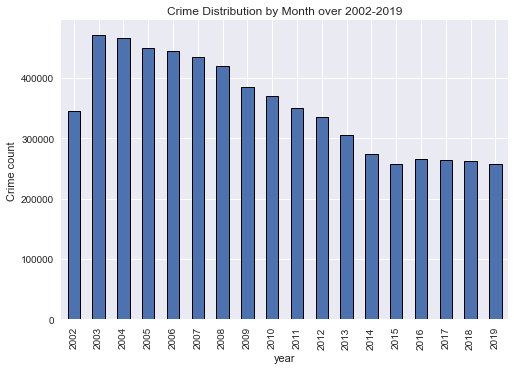

In [6]:
histoy = q1_df.groupby('year').size().plot.bar(edgecolor='black', linewidth=1)
histoy.set_title('Crime Distribution by Month over 2002-2019')
histoy.set_ylabel('Crime count');

One way to gain insight into this question is to see if crime uniformly plateaued (all individual types of crime followed the same pattern as total crime) or if we had a specific spike in one type of crime and reduction in another.

In [69]:
n = 20
top_n_crimes = q1_df.groupby('primary_type').size().sort_values(ascending=False)[:20].index.to_list()

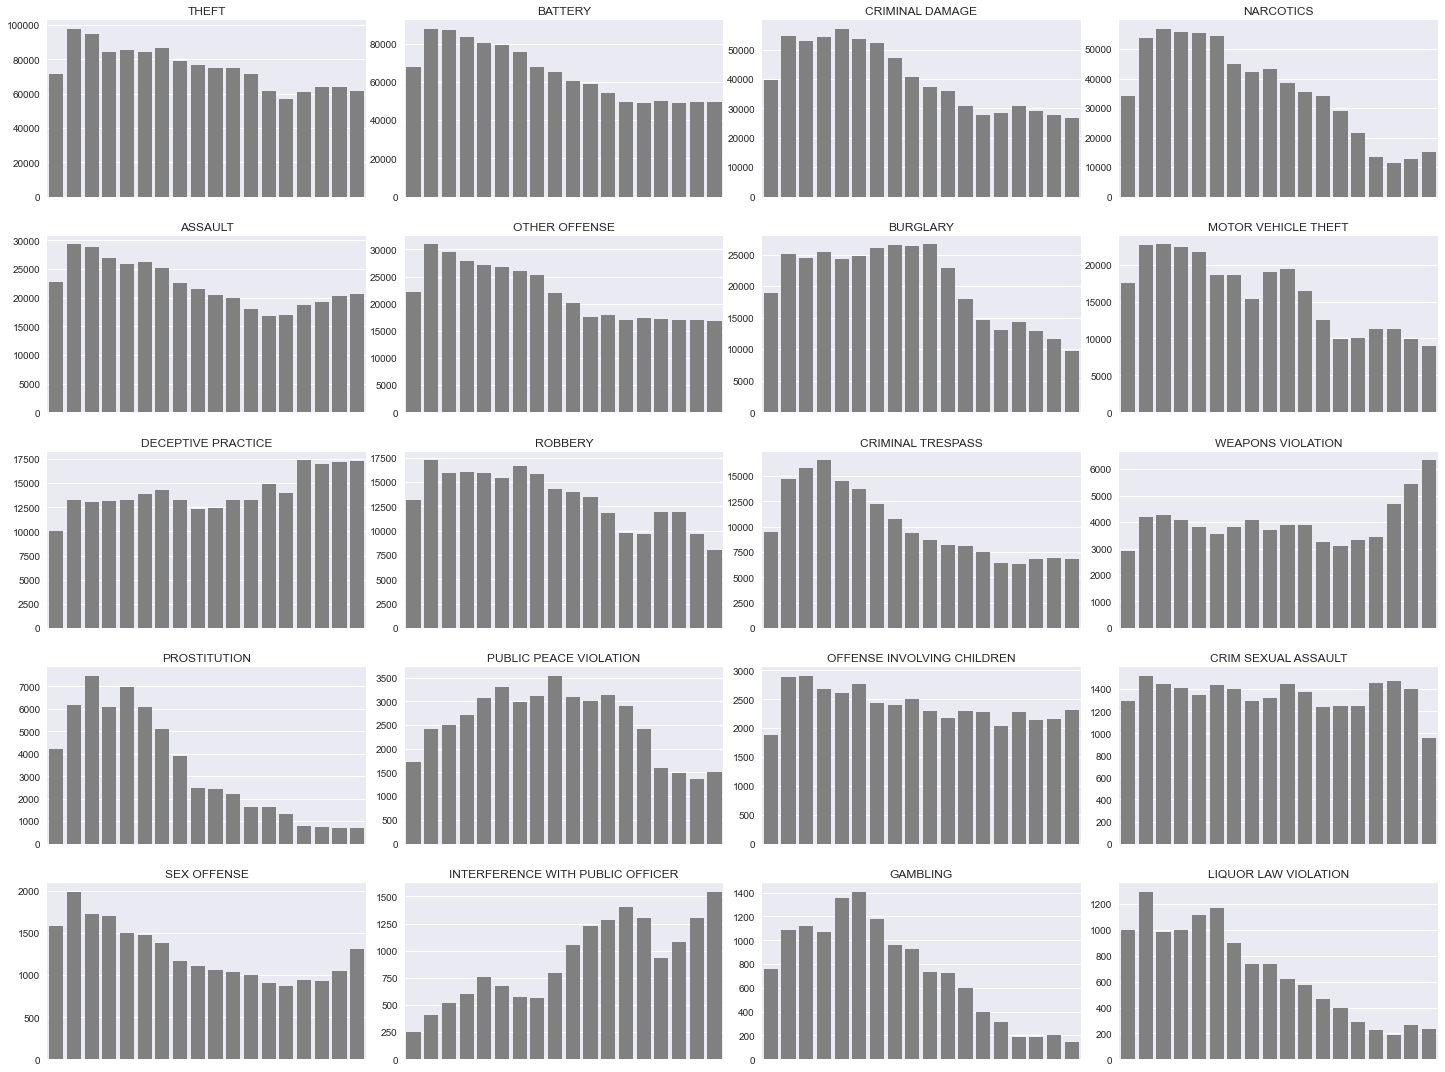

In [72]:
fig, axes = plt.subplots(5, 4, figsize=(20, 15))
fig.tight_layout(h_pad=2)
axes = axes.flatten()
for idx, crime in enumerate(top_n_crimes):
    temp = q1_df[q1_df.primary_type == crime].groupby('year').size()
    x = sns.barplot(ax=axes[idx], x=temp.index, y=temp.values, color='gray')
    axes[idx].set_title(crime)
    x.set(xlabel=None)
    x.set(xticklabels=[])

Looking at the trends in the top 20 crimes, it looks like almost all either plateaued in 2016-2019, with some that increased!  Keeping in mind that these crimes are ordered by frequency, the earlier plots have greater weight.

Let's use linear regression to find the slopes of the 2016-2019 periods for each of these crimes. To get a better handle on  which crimes contribute

In [95]:
from scipy.stats import linregress

def get_slope(df, date_range, crime=None):
    temp = df.copy()
    truncated_df = temp[temp.year.isin(date_range)]
    # If no crime is specified, then we will find
    # the slope of total crime over the date range.
    if not crime:
        number_of_crimes_per_year = truncated_df.groupby('year').size()
    else:
        number_of_crimes_per_year = truncated_df[truncated_df.primary_type == crime].groupby('year').size()
    
    x = date_range
    y = np.array(number_of_crimes_per_year)

    return linregress(x, y).slope

In [98]:
last_4_years = [2016, 2017, 2018, 2019]
crime_types = list(q1_df.primary_type.unique())

print("Report: Trends in last four years for all crimes")
print("-"*30)
print(f"Total Crime Trend: {get_slope(q1_df, last_4_years)} change in crime per year")
last_4_years_trends = [(crime, get_slope(q1_df, last_4_years, crime)) for crime in top_n_crimes]
last_4_years_trends.sort(key=lambda x: x[1], reverse=True)
for crime, change in last_4_years_trends:
    print(f"{crime} Trend: {change} change in crime per year")

Report: Trends in last four years for all crimes
------------------------------
Total Crime Trend: -2622.0 change in crime per year
WEAPONS VIOLATION Trend: 942.6 in crime per year
ASSAULT Trend: 673.2 in crime per year
NARCOTICS Trend: 653.8 in crime per year
THEFT Trend: 235.6 in crime per year
INTERFERENCE WITH PUBLIC OFFICER Trend: 205.5 in crime per year
CRIMINAL TRESPASS Trend: 161.2 in crime per year
SEX OFFENSE Trend: 120.1 in crime per year
OFFENSE INVOLVING CHILDREN Trend: 13.1 in crime per year
LIQUOR LAW VIOLATION Trend: 8.9 in crime per year
DECEPTIVE PRACTICE Trend: -9.8 in crime per year
GAMBLING Trend: -13.1 in crime per year
PROSTITUTION Trend: -37.7 in crime per year
PUBLIC PEACE VIOLATION Trend: -37.8 in crime per year
OTHER OFFENSE Trend: -143.6 in crime per year
CRIM SEXUAL ASSAULT Trend: -157.8 in crime per year
BATTERY Trend: -173.8 in crime per year
MOTOR VEHICLE THEFT Trend: -828.6 in crime per year
ROBBERY Trend: -1408.6 in crime per year
CRIMINAL DAMAGE Trend

If we sum up the total change in crime from the top 20 crimes, we can see that it is representative of the total crime trend:

In [105]:
sum([x[1] for x in last_4_years_trends])

-2736.7000000000003

In our top 20 crimes, nine of them saw net increases and 11 saw net decreases over the period:

In [106]:
len([x[1] for x in last_4_years_trends if x[1] > 0])

9

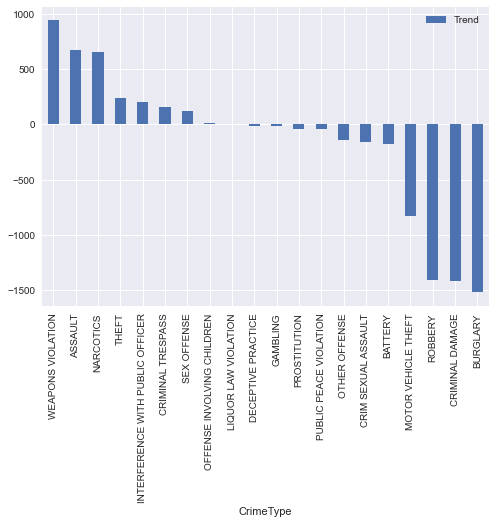

In [113]:
d = {'CrimeType': [x[0] for x in last_4_years_trends], 'Trend': [x[1] for x in last_4_years_trends]}
pd.DataFrame(data=d).plot.bar(x='CrimeType', y='Trend');

Let's compare this data with the solid downward trend in crime that occurred from 2012- 2015

In [114]:
time_domain = [2012, 2013, 2014, 2015]
crime_types = list(q1_df.primary_type.unique())

print("Report: Trends in crime 2012-2015")
print("-"*30)
print(f"Total Crime Trend: {get_slope(q1_df, time_domain)} change in crime per year")
trends = [(crime, get_slope(q1_df, time_domain, crime)) for crime in top_n_crimes]
trends.sort(key=lambda x: x[1], reverse=True)
for crime, change in trends:
    print(f"{crime} Trend: {change} change in crime per year")

Report: Trends in crime 2012-2015
------------------------------
Total Crime Trend: -26470.9 change in crime per year
DECEPTIVE PRACTICE Trend: 364.9 change in crime per year
INTERFERENCE WITH PUBLIC OFFICER Trend: 34.8 change in crime per year
CRIM SEXUAL ASSAULT Trend: -37.5 change in crime per year
OFFENSE INVOLVING CHILDREN Trend: -41.0 change in crime per year
SEX OFFENSE Trend: -60.4 change in crime per year
LIQUOR LAW VIOLATION Trend: -91.6 change in crime per year
GAMBLING Trend: -144.5 change in crime per year
OTHER OFFENSE Trend: -162.1 change in crime per year
WEAPONS VIOLATION Trend: -185.0 change in crime per year
PUBLIC PEACE VIOLATION Trend: -201.3 change in crime per year
PROSTITUTION Trend: -267.2 change in crime per year
CRIMINAL TRESPASS Trend: -606.9 change in crime per year
ASSAULT Trend: -978.3 change in crime per year
ROBBERY Trend: -1357.1 change in crime per year
MOTOR VEHICLE THEFT Trend: -2213.1 change in crime per year
CRIMINAL DAMAGE Trend: -2485.9 change i

Wow, this really highlights the plateau!  From 2012-2015, nearly ALL crimes were decreasing!

If we sum up the total change in crime from the top 20 crimes, we can again see that it is representative of the total crime trend:

In [115]:
sum([x[1] for x in trends])

-26448.5

In our top 20 crimes, only two of them saw net increases and 18 saw net decreases over the period:

In [117]:
len([x[1] for x in trends if x[1] > 0])

2

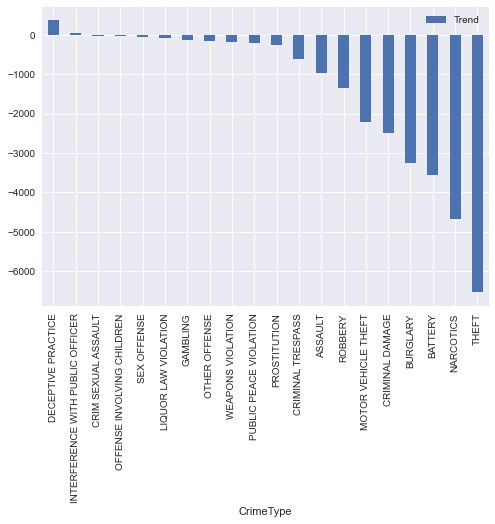

In [118]:
d = {'CrimeType': [x[0] for x in trends], 'Trend': [x[1] for x in trends]}
pd.DataFrame(data=d).plot.bar(x='CrimeType', y='Trend');

Let's compare the two periods in a visualization

In [126]:
df_trends_2016_2019 = pd.DataFrame({'CrimeType': [x[0] for x in last_4_years_trends], '2016-2019': [x[1] for x in last_4_years_trends]})
df_trends_2012_2015 = pd.DataFrame({'CrimeType': [x[0] for x in trends], '2012-2015': [x[1] for x in trends]})
trend_df = df_trends_2012_2015.join(df_trends_2016_2019.set_index('CrimeType'), on='CrimeType').set_index('CrimeType')

In [127]:
trend_df

,2012-2015,2016-2019
CrimeType,,
DECEPTIVE PRACTICE,364.9,-9.8
INTERFERENCE WITH PUBLIC OFFICER,34.8,205.5
CRIM SEXUAL ASSAULT,-37.5,-157.8
OFFENSE INVOLVING CHILDREN,-41.0,13.1
SEX OFFENSE,-60.4,120.1
LIQUOR LAW VIOLATION,-91.6,8.9
GAMBLING,-144.5,-13.1
OTHER OFFENSE,-162.1,-143.6
WEAPONS VIOLATION,-185.0,942.6


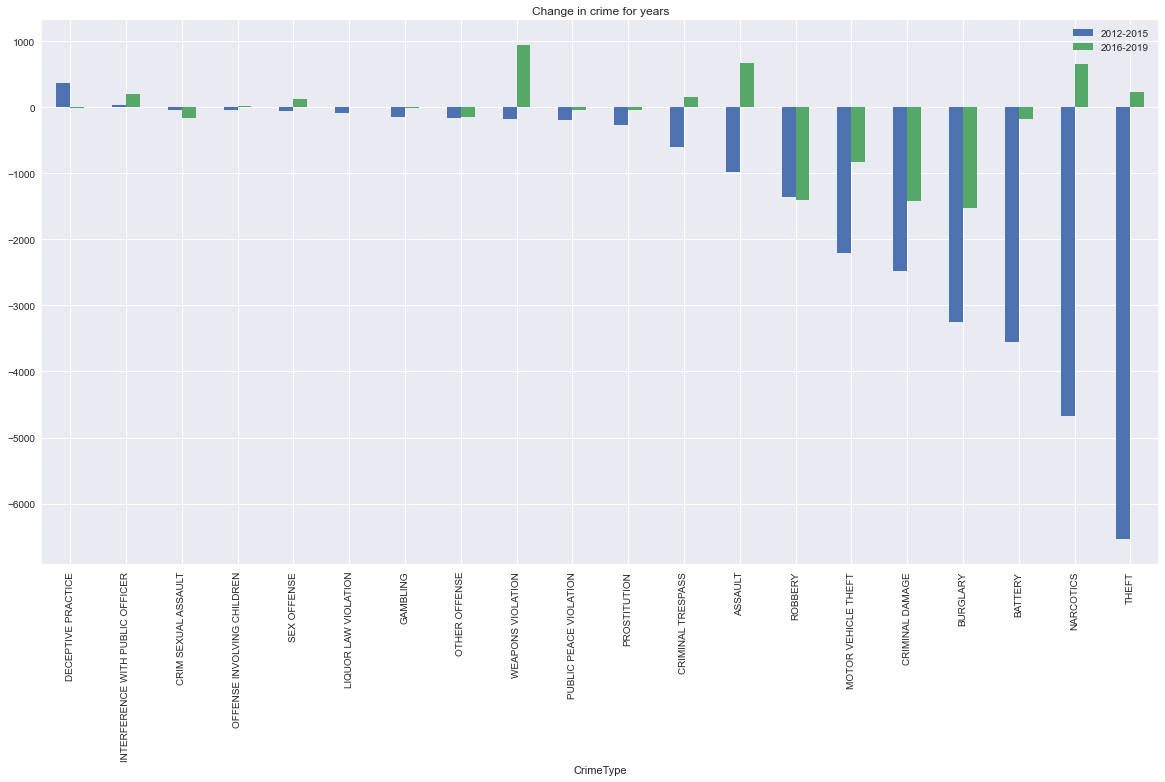

In [131]:
trend_df.plot.bar(figsize=(20,10), title="Change in crime for years");

Our conclusion: the plateau in crime was driven by certain frequent crimes no longer decreasing (theft, narcotics), but rather increasing!